In [2]:
import numpy as np
import pandas as pd
import altair as alt
import seaborn as sns

import weather
import plants

import importlib

In [3]:
importlib.reload(weather)

<module 'weather' from '/Users/oneoPk/Desktop/Classes/330/final-project/weather.py'>

In [4]:
importlib.reload(plants)

<module 'plants' from '/Users/oneoPk/Desktop/Classes/330/final-project/plants.py'>

In [5]:
# showing only 10 rows when trying to print the whole pandas dataset 
pd.options.display.max_rows = 15

# Effects of **Climate** on **Botrytis Infection** in Peonies 

## 1. Weather Data
First, I am geting the data from the **weather api** for the appropriate months

In [6]:
# shorthand notation for the relelvant cities
AA = "Ann Arbor, MI"
MSK = "Minsk, Belarus"

# this are the date blocks to fetch
april     = ['04-15','04-30']
may       = ['05-01','05-31']
june      = ['06-01','06-30']
july      = ['07-01','07-31']
august    = ['08-01','08-31']
september = ['09-01','09-30']

def get_weather_data(city,months,years,file):
    # Request to API and Dumping data to CSV
    data = weather.get_weather_data(city,years,months)
    weather.dump_to_csv(file, days = data)

    # reading weather into pandas dataframe
    df = pd.read_csv(file)

    # coverting the date column into a 'datetime' column
    df.date = df.date.astype('datetime64[ns]')
    
    # making the column with average temperature
    df['avgtempC'] = (df['maxtempC'] + df['mintempC'])/2

    
    # returning the result
    return df

In [7]:
#### GETTING WEATHER FOR ANN ARBOR ####
city   = AA
months = [may,june,july,august]
years  = [2012,2013,2014,2015,2016,2017,2018]
file   = 'aa_weather.csv'

# getting weather data for each day of given month
aa_weather_df = get_weather_data(city,months,years,file)

# need to calculate averages for each year
aa_weather_mean_by_year_df = aa_weather_df.groupby(aa_weather_df.date.dt.year).mean()

In [8]:
#### GETTING WEATHER FOR MINSK ####
city   = MSK
months = [may,june,july,august]
years  = [2012,2013,2014,2015,2016,2017,2018]
file   = 'msk_weather.csv'

# getting weather data for each day of given month
msk_weather_df = get_weather_data(city,months,years,file)

# need to calculate averages for each year
msk_weather_mean_by_year_df = msk_weather_df.groupby(msk_weather_df.date.dt.year).mean()

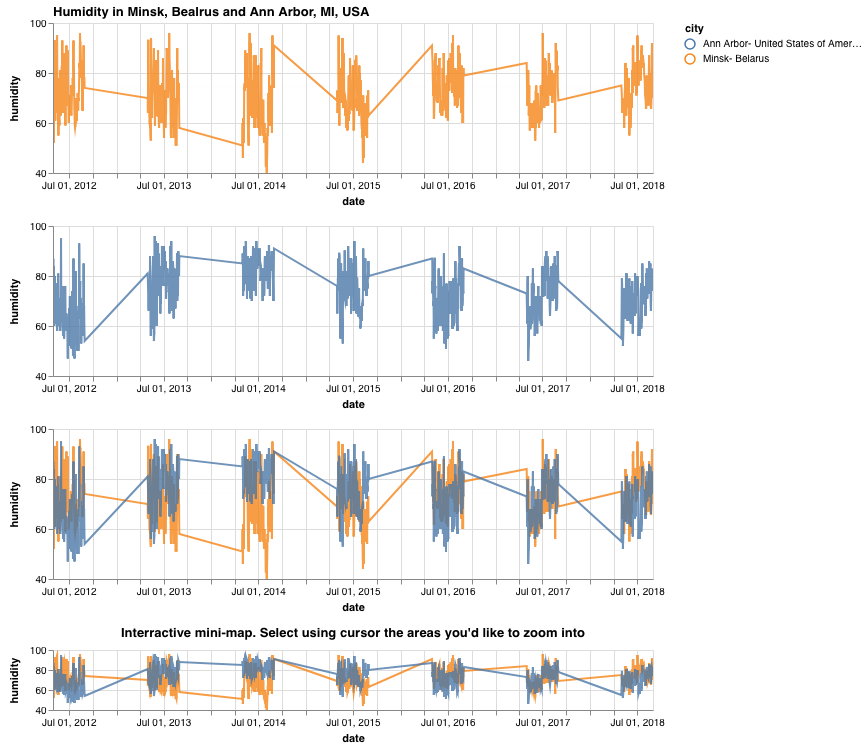

In [9]:
brush = alt.selection(type='interval', encodings=['x'])

msk = alt.Chart(msk_weather_df).mark_line().encode(
    x=alt.X('date:T', scale={'domain': brush.ref()}),
    y=alt.Y('humidity:Q',scale = {'domain':(40, 100)})
).properties(
    width=600,
    height=150
).encode(color='city:N')


aa = alt.Chart(aa_weather_df).mark_line().encode(
    x=alt.X('date:T', scale={'domain': brush.ref()}),
    y=alt.Y('humidity:Q',scale = {'domain':(40, 100)})
).properties(
    width=600,
    height=150
).encode(color='city:N')

lower =(msk.properties(
    height=60,
    width=600
)+aa.add_selection(brush)).properties(title="Interractive mini-map. Select using cursor the areas you'd like to zoom into")

alt.vconcat(msk,aa,msk+aa,lower).properties(title='Humidity in Minsk, Bealrus and Ann Arbor, MI, USA').configure_mark(opacity=0.8)

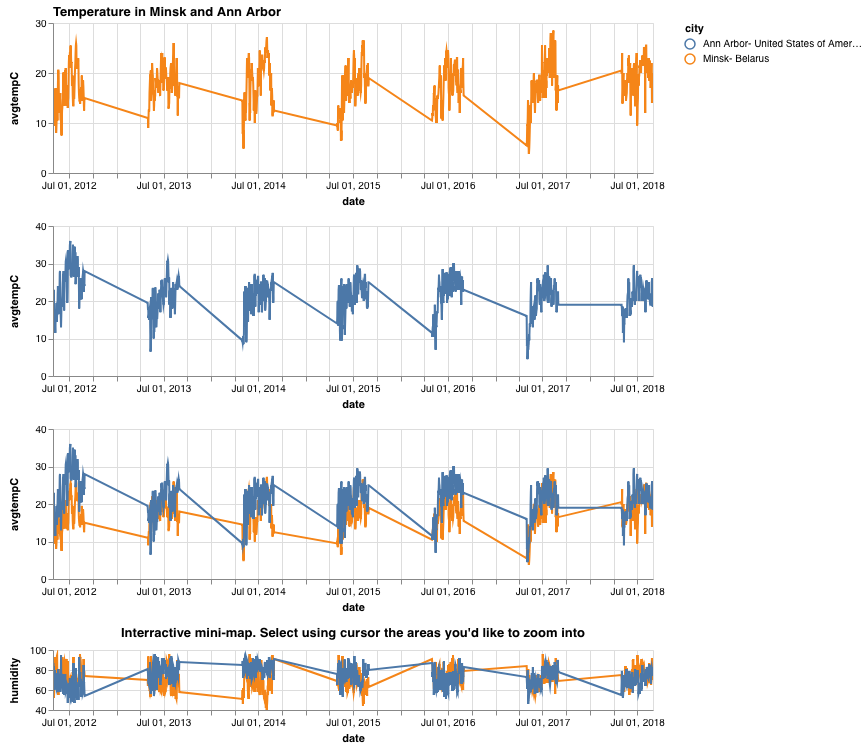

In [38]:
msk = msk.encode(y=alt.Y('avgtempC:Q'))
aa = aa.encode(y=alt.Y('avgtempC:Q')) 
alt.vconcat(msk,aa,msk+aa,lower).properties(title='Temperature in Minsk and Ann Arbor')

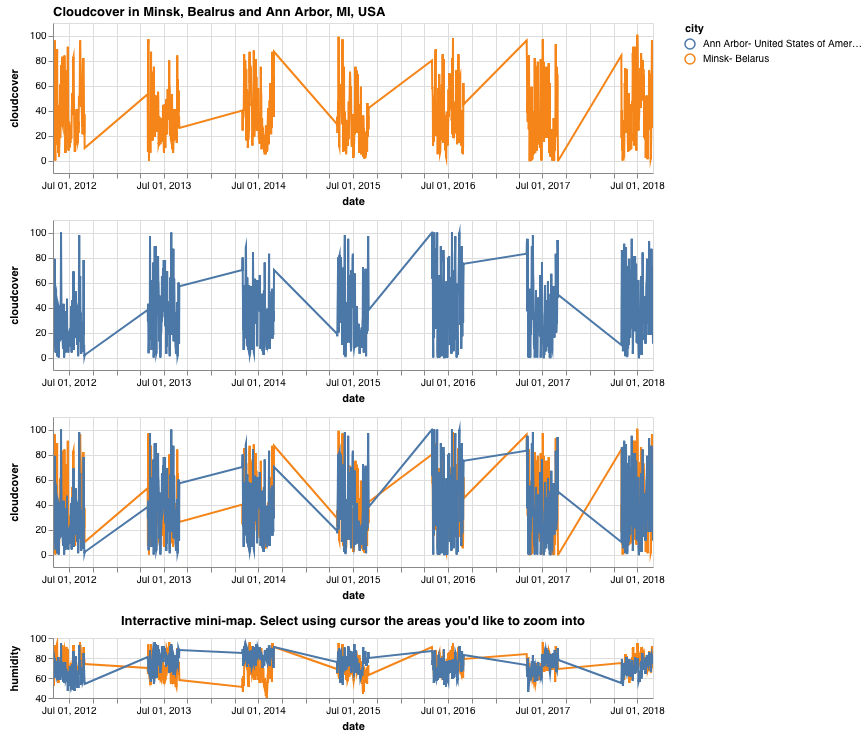

In [11]:
msk = msk.encode(y=alt.Y('cloudcover:Q',scale = {'domain':(-10, 110)}))
aa = aa.encode(y=alt.Y('cloudcover:Q',scale = {'domain':(-10, 110)}))
alt.vconcat(msk,aa,msk+aa,lower).properties(title='Cloudcover in Minsk, Bealrus and Ann Arbor, MI, USA')

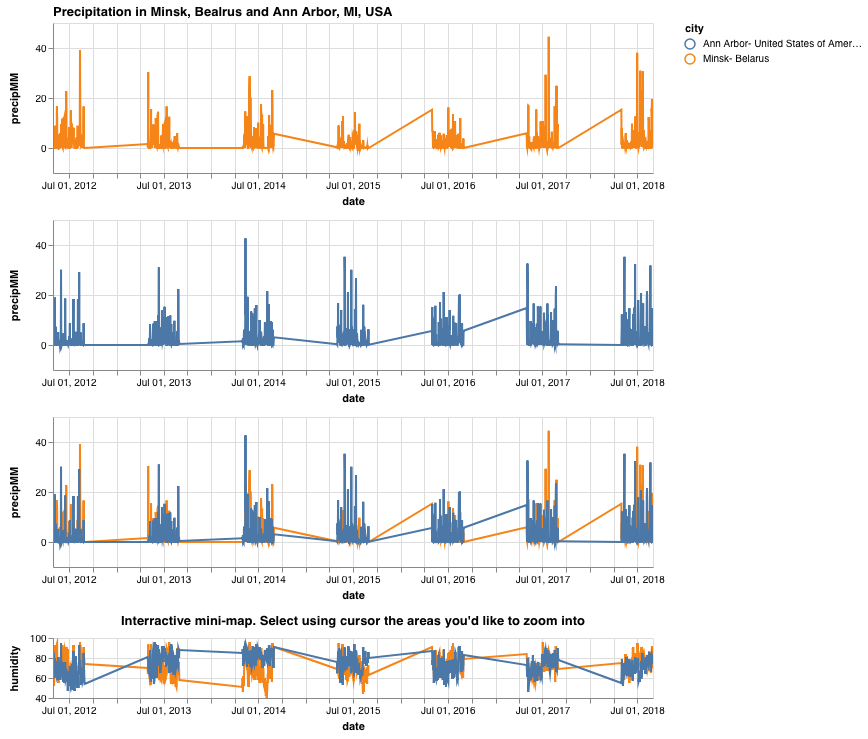

In [12]:
msk = msk.encode(y=alt.Y('precipMM:Q',scale = {'domain':(-10, 50)})).mark_line()
aa = aa.encode(y=alt.Y('precipMM:Q',scale = {'domain':(-10, 50)})).mark_line()
alt.vconcat(msk,aa,msk+aa,lower).properties(title='Precipitation in Minsk, Bealrus and Ann Arbor, MI, USA')

## 2. Plants Data
Second, I am going to collect the plants' morphological properties into a pandas dataframe to combine with weather data

In [13]:
file_name = 'data/plants/msk_aa_15-18.xlsx'
sheet_nums = [4,5,6,7]
column_names = ["No",
                "genetic_Acc_No",
                "num",
                "Cultivar",
                "Serial_No",
                "ID",
                "Regidity",
                "Thickness",
                "Bush",
                "Early_Bot",
                "Bot",
                "Mildew",
                "date",
                "City"]

plants_aa_df = plants.read_excel(file_name, sheet_nums = sheet_nums, na_values=['NA','Na'], column_names=column_names)

In [14]:
plants_aa_df.tail()

,No,genetic_Acc_No,num,Cultivar,Serial_No,ID,Regidity,Thickness,Bush,Early_Bot,Bot,Mildew,date,City
28,53.0,53.1,53.2,Polar Star,377.0,154AB,4.25,1.041667,4.5,NaN,0.020,0.1,2018-07-26,Ann Arbor
29,54.0,54.1,54.2,Edulus Superba,97.0,42AB,4.15,0.880000,4.5,NaN,0.200,NaN,2018-07-26,Ann Arbor
30,106.0,106.1,106.2,Kansas,NaN,24CD,4.50,1.155000,4.5,NaN,0.150,1.5,2018-07-26,Ann Arbor
31,112.0,112.1,112.2,Richard Carvel,NaN,44EF,NaN,NaN,NaN,NaN,NaN,NaN,2018-07-26,Ann Arbor
32,113.0,113.1,113.2,Richardson Perfection,NaN,124CD,3.75,1.031667,3.5,NaN,0.075,NaN,2018-07-26,Ann Arbor


## 3. Combining both

Finally, it is time to combine the weather data with the plants data

First, lets take a look at the weather data average by years

In [15]:
msk_weather_mean_by_year_df

,maxtempC,mintempC,precipMM,humidity,cloudcover,avgtempC
date,,,,,,
2012,22.138211,11.617886,3.608943,72.853659,38.593496,16.878049
2013,23.544715,12.601626,2.954472,70.081301,32.739837,18.073171
2014,24.138211,12.024390,3.405691,67.837398,38.699187,18.081301
2015,23.146341,11.211382,1.502439,68.991870,32.617886,17.178862
2016,22.463415,12.373984,2.100813,74.723577,37.016260,17.418699
2017,20.756098,14.788618,3.184553,71.357724,36.707317,17.772358
2018,21.943089,16.666667,3.470732,75.642276,43.398374,19.304878


In [16]:
aa_weather_mean_by_year_df

,maxtempC,mintempC,precipMM,humidity,cloudcover,avgtempC
date,,,,,,
2012,29.569106,19.634146,2.061789,64.422764,24.926829,24.601626
2013,25.073171,16.951220,2.753659,77.138211,37.113821,21.012195
2014,24.967480,16.471545,3.622764,82.170732,34.040650,20.719512
2015,26.195122,17.365854,3.277236,75.560976,39.560976,21.780488
2016,26.455285,17.772358,3.247967,70.861789,44.146341,22.113821
2017,24.373984,16.219512,3.739837,72.032520,31.479675,20.296748
2018,25.186992,16.829268,4.651220,70.934959,42.341463,21.008130


It looks like year is in a string format and is the only connection between two datasets <br>
Going to create a new column  **year** to match `weather` and `plants` on

In [17]:
plants_aa_df['year'] = plants_aa_df.date.apply(lambda x: str(x)[0:4])

In [18]:
plants_aa_df.sample(4)

,No,genetic_Acc_No,num,Cultivar,Serial_No,ID,Regidity,Thickness,Bush,Early_Bot,Bot,Mildew,date,City,year
8,33.0,33.1,33.2,Duchesse de Nemours,5.0,11EF,NaN,8.500,NaN,NaN,1.50,0.125,2015-07-11,Ann Arbor,2015
7,32.0,32.1,32.2,Duc de Wellington,477.0,195EF,3.50,7.925,3.5,NaN,0.88,0.000,2015-07-11,Ann Arbor,2015
10,35.0,35.1,35.2,Fortune Teller,219.0,85ED,3.50,NaN,3.5,NaN,0.10,NaN,2017-07-10,Ann Arbor,2017
25,50.0,50.1,50.2,Octavie Demay,61.0,31AB,3.75,NaN,4.0,NaN,0.30,NaN,2018-07-26,Ann Arbor,2018


both columns must be the same format

In [19]:
plants_aa_df.year = plants_aa_df.year.astype('str')
aa_weather_mean_by_year_df.index = aa_weather_mean_by_year_df.index.astype('str')

now we can combine two datasets

In [20]:
plants_weather_aa_df = plants_aa_df.merge(aa_weather_mean_by_year_df, left_on='year', right_on='date')

In [21]:
plants_weather_aa_df.head()

,No,genetic_Acc_No,num,Cultivar,Serial_No,ID,Regidity,Thickness,Bush,Early_Bot,...,Mildew,date,City,year,maxtempC,mintempC,precipMM,humidity,cloudcover,avgtempC
0,25.0,25.1,25.2,Albert Crousse,391.0,161CD,3.125,7.285,3.00,NaN,...,0.0,2015-07-11,Ann Arbor,2015,26.195122,17.365854,3.277236,75.560976,39.560976,21.780488
1,26.0,26.1,26.2,Arcturus,115.0,45AB,2.750,6.100,3.00,NaN,...,0.1,2015-07-11,Ann Arbor,2015,26.195122,17.365854,3.277236,75.560976,39.560976,21.780488
2,27.0,27.1,27.2,Arlequin,73.0,33AB,3.000,7.250,4.00,NaN,...,0.0,2015-07-11,Ann Arbor,2015,26.195122,17.365854,3.277236,75.560976,39.560976,21.780488
3,28.0,28.1,28.2,Augustin D'Hour = General MacMahon,383.0,155AB,3.500,8.450,4.25,NaN,...,0.0,2015-07-11,Ann Arbor,2015,26.195122,17.365854,3.277236,75.560976,39.560976,21.780488
4,29.0,29.1,29.2,Boule de Neige,211.0,84CD,4.000,8.935,4.00,NaN,...,0.0,2015-07-11,Ann Arbor,2015,26.195122,17.365854,3.277236,75.560976,39.560976,21.780488


## 4. Combined Data Processing

I'd like to find the  top plants that are **most** resistant to Botrytis (Bot) <br>
Specifically I am looking for plant that have never gone above **threshold** in Bot column

In [22]:
# setting the cutoff threshold
threshold = 0.4

# grouping the plants by the name and looking for the maximum infection level within plant
max_bot_df = plants_weather_aa_df.groupby('Cultivar').Bot.max()

# finding most resistant based on the threshold
most_resistant = max_bot_df[max_bot_df < threshold]
print(most_resistant)
most_resistant_list = most_resistant.index

# filtering the original dataframe with all the plants to select only the most resistant
most_resistant_df = plants_weather_aa_df[ plants_weather_aa_df.Cultivar.isin(most_resistant_list) ]

Cultivar
Couronne d'Or            0.350
Do Tell                  0.100
Fortune Teller           0.150
Kansas                   0.150
La Perle                 0.200
Marie Lemoine            0.300
Polar Star               0.200
Richardson Perfection    0.075
Name: Bot, dtype: float64


let's take a look at what the __most resistant__ look like

In [23]:
most_resistant_df['Cultivar'].value_counts()

Polar Star               4
La Perle                 4
Couronne d'Or            4
Fortune Teller           4
Marie Lemoine            4
Do Tell                  4
Richardson Perfection    3
Kansas                   3
Name: Cultivar, dtype: int64

removing Richardson Perfection and Kansas as it has only 1 record and might be not good data

In [24]:
most_resistant_df = most_resistant_df[most_resistant_df.Cultivar != 'Richardson Perfection']
most_resistant_df = most_resistant_df[most_resistant_df.Cultivar != 'Kansas']

most_resistant_df['Cultivar'].value_counts()

Polar Star        4
La Perle          4
Couronne d'Or     4
Marie Lemoine     4
Do Tell           4
Fortune Teller    4
Name: Cultivar, dtype: int64

<br>Now, looking for plants that are **least** resistant [susceptible] to Botrytis (Bot) <br>
Specifically I am looking for plant that have never gone lower than **threshold** in Bot column

In [25]:
# finding least resistant based on the threshold
least_resistant = max_bot_df[max_bot_df > 1.5]
print(least_resistant)
least_resistant_list = least_resistant.index

# filtering the original dataframe with all the plants to select only the most resistant
least_resistant_df = plants_weather_aa_df[ plants_weather_aa_df.Cultivar.isin(least_resistant_list) ]

Cultivar
Arcturus                2.00
Arlequin                2.00
Boule de Neige          2.00
Edulus Superba          2.00
La Rosiere              2.60
Madame de Verneville    2.00
Marie d'Hour            1.75
Monsieur Dupont         2.00
Monsieur Jules Elie     2.75
Octavie Demay           3.00
Name: Bot, dtype: float64


## 5. Visual Exploration

#### Defining a function that can display interractive scatterplots via Altair 

In [26]:
def bot_interractive_scatterplots(source, title):
    brush = alt.selection(type='interval', resolve='global')

    base = alt.Chart(source).mark_circle(size = 125).encode(
        alt.X('Bot:Q'),
    #     color = 'Cultivar:N',
        color=alt.condition(brush, 'Cultivar', alt.ColorValue('gray'))
    #     shape = 'Cultivar:O',
    #     size = 'Bot:Q'
    ).add_selection(
        brush
    ).properties(
        width=250,
        height=250
    )

    # definign scale for y
    s_temp   = alt.Scale(domain=(20, 23))
    s_humid  = alt.Scale(domain=(69, 77))
    s_percip = alt.Scale(domain=(3, 5))
    s_cloud  = alt.Scale(domain=(30, 46))

    # plotting graphs next to each other
    return (base.encode(alt.Y('avgtempC',scale = s_temp))|\
    base.encode(alt.Y('humidity',scale = s_humid))|\
    base.encode(alt.Y('precipMM',scale = s_percip))|\
    base.encode(alt.Y('cloudcover',scale = s_cloud))).properties(title=title)

now using the function to plot **Most Resistant Species**

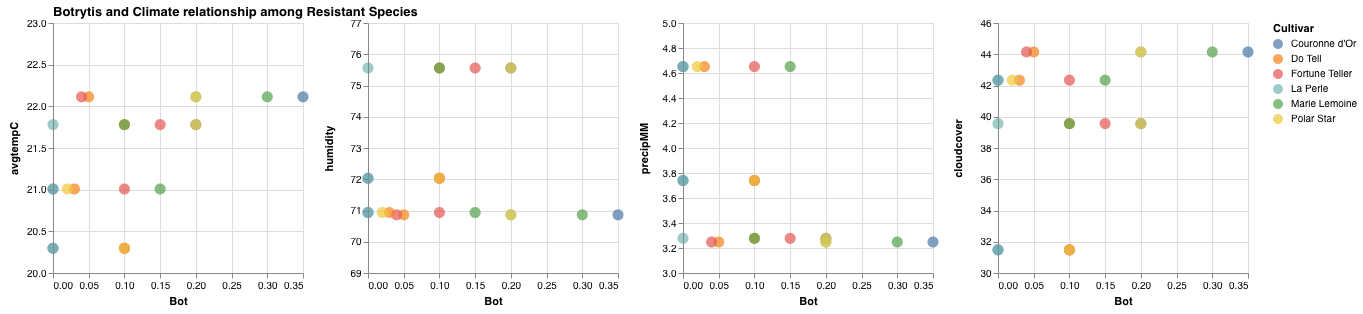

In [27]:
bot_interractive_scatterplots(most_resistant_df,'Botrytis and Climate relationship among Resistant Species')

now same but for  **Less Resistant Species**

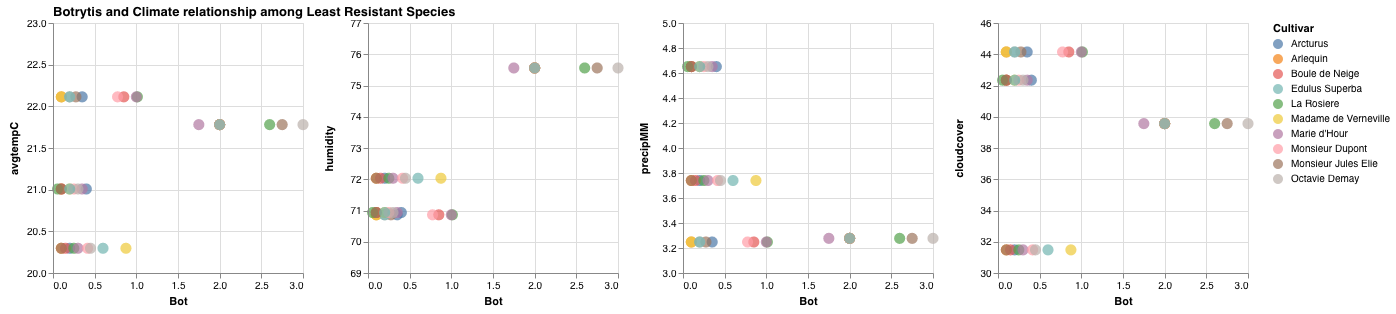

In [28]:
bot_interractive_scatterplots(least_resistant_df,'Botrytis and Climate relationship among Least Resistant Species')

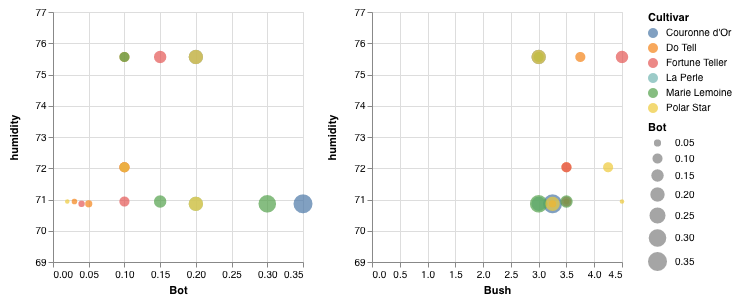

In [29]:
source = most_resistant_df


brush = alt.selection(type='interval', resolve='global')

base = alt.Chart(source).mark_circle().encode(
    alt.Y('humidity:Q',scale=alt.Scale(domain=(69, 77),clamp=True)),
    size='Bot:Q',
    color=alt.condition(brush, 'Cultivar', alt.ColorValue('gray'))
).add_selection(
    brush
).properties(
    width=250,
    height=250
)

base.encode(x='Bot') | base.encode(x='Bush')

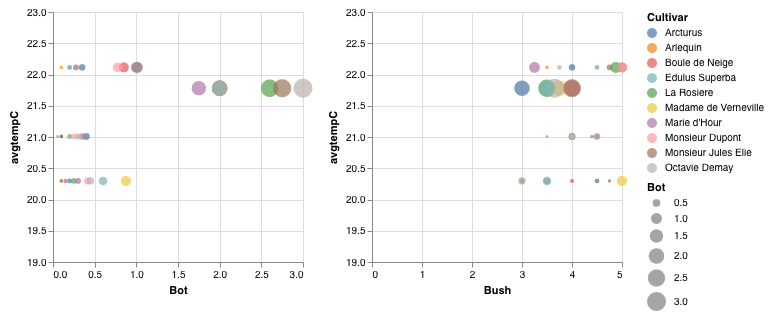

In [30]:
source = least_resistant_df


base = alt.Chart(source).mark_circle().encode(
    alt.Y('avgtempC:Q',scale=alt.Scale(domain=(19, 23),clamp=True)),
    size='Bot:Q',
    color=alt.condition(brush, 'Cultivar:N', alt.ColorValue('gray'))
).add_selection(
    brush
).properties(
    width=250,
    height=250
)

base.encode(x='Bot') | base.encode(x='Bush')


Plotting the __most resistant__ species to see if there might be correlation between climate and infections level

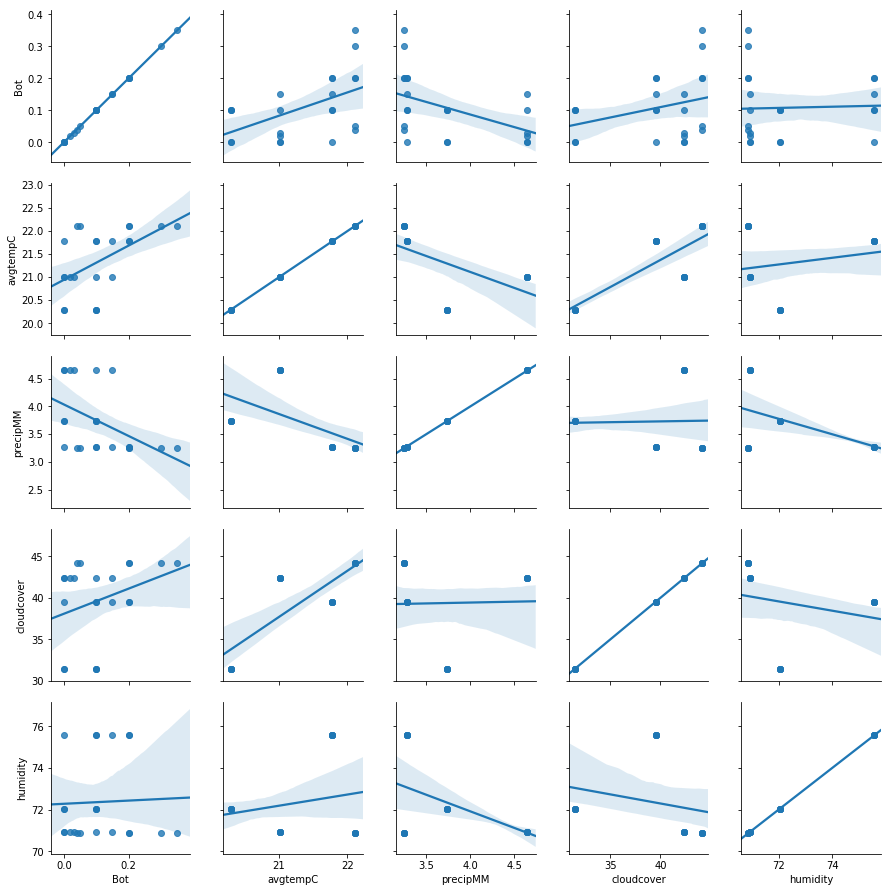

In [31]:
g = sns.PairGrid(most_resistant_df, vars=['Bot','avgtempC', 'precipMM', 'cloudcover','humidity'])
g.map(sns.regplot)

Now same process but for __least resistant__

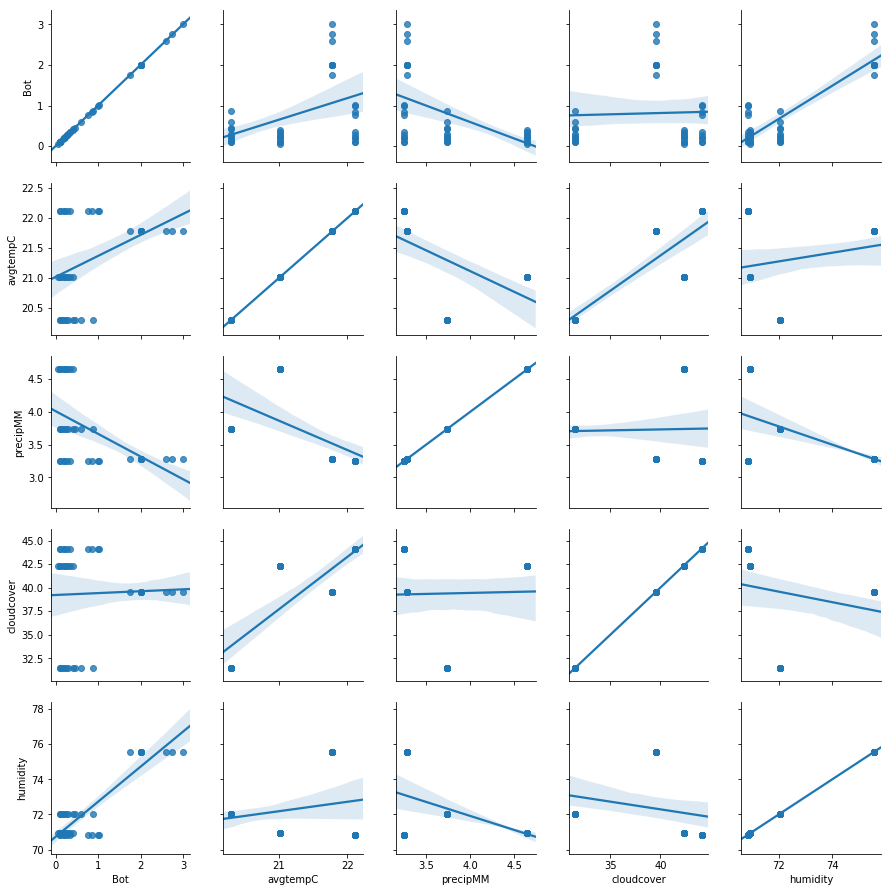

In [32]:
g = sns.PairGrid(least_resistant_df, vars=['Bot','avgtempC', 'precipMM', 'cloudcover','humidity'])
g.map(sns.regplot)

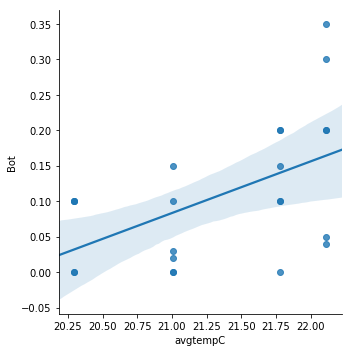

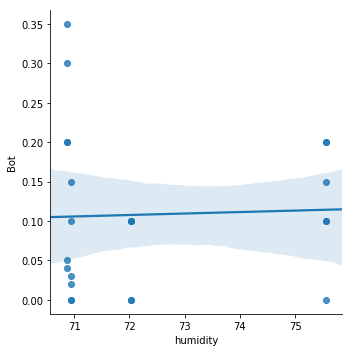

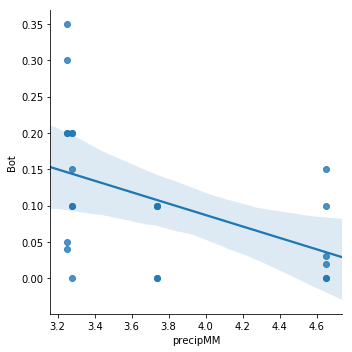

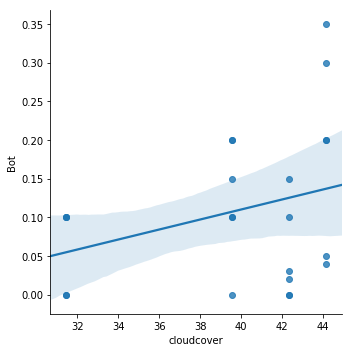

In [33]:
df_temp = most_resistant_df

mr1 = sns.lmplot(x='avgtempC', y='Bot', data=df_temp)
mr2 = sns.lmplot(x='humidity', y='Bot', data=df_temp)
mr2 = sns.lmplot(x='precipMM', y='Bot', data=df_temp)
mr2 = sns.lmplot(x='cloudcover', y='Bot', data=df_temp)

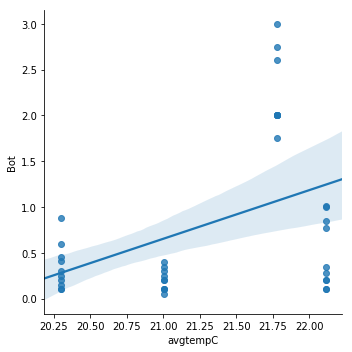

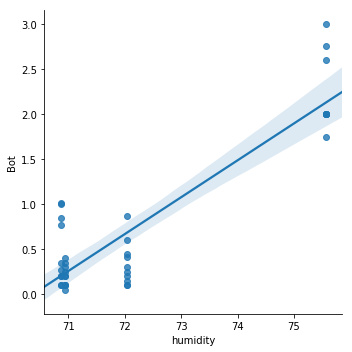

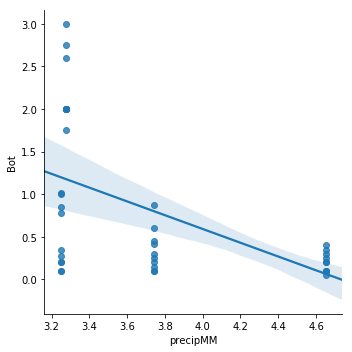

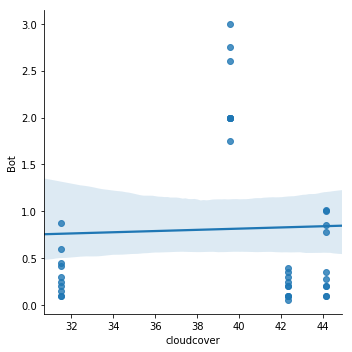

In [34]:
df_temp = least_resistant_df
mr1 = sns.lmplot(x='avgtempC', y='Bot', data=df_temp)
mr2 = sns.lmplot(x='humidity', y='Bot', data=df_temp)
mr2 = sns.lmplot(x='precipMM', y='Bot', data=df_temp)
mr2 = sns.lmplot(x='cloudcover', y='Bot', data=df_temp)

### This is the correlation for the __most__ resistant cultivars

In [35]:
most_resistant_df[['avgtempC','humidity','precipMM','cloudcover','Bot']].corr(method = 'pearson')

,avgtempC,humidity,precipMM,cloudcover,Bot
avgtempC,1.000000,0.197314,-0.556154,0.807600,0.520022
humidity,0.197314,1.000000,-0.471050,-0.221062,0.037895
precipMM,-0.556154,-0.471050,1.000000,0.024654,-0.472540
cloudcover,0.807600,-0.221062,0.024654,1.000000,0.312931
Bot,0.520022,0.037895,-0.472540,0.312931,1.000000


### This is the correlation for the **least** resistant cultivars

In [36]:
least_resistant_df[['avgtempC','humidity','precipMM','cloudcover','Bot']].corr(method = 'pearson')

,avgtempC,humidity,precipMM,cloudcover,Bot
avgtempC,1.000000,0.197314,-0.556154,0.807600,0.431747
humidity,0.197314,1.000000,-0.471050,-0.221062,0.903119
precipMM,-0.556154,-0.471050,1.000000,0.024654,-0.529290
cloudcover,0.807600,-0.221062,0.024654,1.000000,0.035850
Bot,0.431747,0.903119,-0.529290,0.035850,1.000000


In [37]:
## useful wrappers

# selecting only certain date
year = 2016
plants_df_2016 = plants_df[ plants_df.date.dt.year == year ]

# selecting only certain plant
plant_ids = ['161CD', '45AB','162CD']
plants_df_specific = plants_df[ plants_df.ID.isin(plant_ids) ]

# sorting the df
plants_df.sort_values(by=['ID'],ascending=False)

# only the needed columns
most_resistant_df_scatter = most_resistant_df[['Bot','precipMM','humidity','cloudcover','avgtempC']]

NameError: name 'plants_df' is not defined

In [ ]:
import json  # need it for json.dumps
import altair as alt
from altair.vega import v3
from IPython.display import HTML

# Create the correct URLs for require.js to find the Javascript libraries
vega_url = 'https://cdn.jsdelivr.net/npm/vega@' + v3.SCHEMA_VERSION
vega_lib_url = 'https://cdn.jsdelivr.net/npm/vega-lib'
vega_lite_url = 'https://cdn.jsdelivr.net/npm/vega-lite@' + alt.SCHEMA_VERSION
vega_embed_url = 'https://cdn.jsdelivr.net/npm/vega-embed@3'
noext = "?noext"

paths = {
    'vega': vega_url + noext,
    'vega-lib': vega_lib_url + noext,
    'vega-lite': vega_lite_url + noext,
    'vega-embed': vega_embed_url + noext
}

workaround = """
requirejs.config({{
    baseUrl: 'https://cdn.jsdelivr.net/npm/',
    paths: {paths}
}});
"""

HTML("".join((
    "<script>",
    workaround.format(paths=json.dumps(paths)),
    "</script>",
    "This code block sets up embedded rendering in HTML."
)))

In [ ]:
# Define the function for rendering
def add_autoincrement(render_func):
    # Keep track of unique <div/> IDs
    cache = {}
    def wrapped(chart, id="vega-chart", autoincrement=True):
        """Render an altair chart directly via javascript.
        
        This is a workaround for functioning export to HTML.
        (It probably messes up other ways to export.) It will
        cache and autoincrement the ID suffixed with a
        number (e.g. vega-chart-1) so you don't have to deal
        with that.
        """
        if autoincrement:
            if id in cache:
                counter = 1 + cache[id]
                cache[id] = counter
            else:
                cache[id] = 0
            actual_id = id if cache[id] == 0 else id + '-' + str(cache[id])
        else:
            if id not in cache:
                cache[id] = 0
            actual_id = id
        return render_func(chart, id=actual_id)
    # Cache will stay defined and keep track of the unique div Ids
    return wrapped


@add_autoincrement
def render(chart, id="vega-chart"):
    # This below is the javascript to make the chart directly using vegaEmbed
    chart_str = """
    <div id="{id}"></div><script>
    require(["vega-embed"], function(vegaEmbed) {{
        const spec = {chart};     
        vegaEmbed("#{id}", spec, {{defaultStyle: true}}).catch(console.warn);
    }});
    </script>
    """
    return HTML(
        chart_str.format(
            id=id,
            chart=json.dumps(chart) if isinstance(chart, dict) else chart.to_json(indent=None)
        )
    )